In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn
import random
import importlib
resources = importlib.import_module("resources")
import resources.finiteMDP as fmdp
import resources.infMDP as imdp
from itertools import product
random.seed(2018)

%matplotlib inline



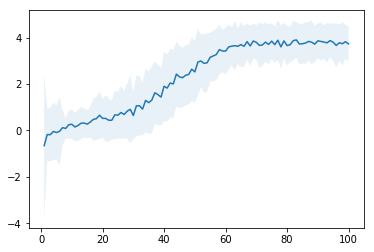

In [5]:
# GridWorld

states = list(range(22)) ; states.append('inf')
actions = ["AU","AD","AL","AR"]
action_id = {"AU":0,"AD":1,"AL":2,"AR":3}
action_dict= {"AU":[.8,0,.05,.05,.1],
              "AL":[.05,.05,.8,0,.1],
              "AR":[.05,.05,0,.8,.1],
              "AD":[0,.8,.05,.05,.1]}
                #   U D L R C
transition_dict = {0:[0,5,0,1,0],
                   1:[0,5,-1,1,0],
                   2:[0,5,-1,1,0],
                   3:[0,5,-1,1,0],
                   4:[0,5,-1,0,0],
                   5:[-5,5,0,1,0],
                   6:[-5,5,-1,1,0],
                   7:[-5,0,-1,1,0],
                   8:[-5,4,-1,1,0],
                   9:[-5,4,-1,0,0],
                  10:[-5,4,0,1,0],
                  11:[-5,4,-1,0,0],
                  12:[-4,4,0,1,0],
                  13:[-4,4,-1,0,0],
                  14:[-4,4,0,1,0],
                  15:[-4,4,-1,0,0],
                  16:[-4,5,0,1,0],
                  17:[-4,None,-1,0,0],
                  18:[-4,0,0,1,0],
                  19:[-4,0,-1,1,0],
                  20:[0,0,-1,1,0],
                  21:[-5,0,-1,None,0]}
def transition_func(state,action):
    direction = np.random.choice(list(range(5)),p = action_dict[action])
    change = transition_dict[state][direction]
    if change is None:
        return 'inf'
    else:
        return state + change
def reward_func(state,action,newstate):
    if newstate ==20:
        return -10
    elif newstate == 'inf':
        return 10
    else:
        return 0
def policy_random(state,actions):
    return random.choice(actions)
myMDP = fmdp.MDP(states,actions,transition_func,reward_func,lambda : 0, .9, policy_random)

episodes = 100
repetitions = 100
y = np.zeros((episodes,repetitions))
j=0
while j<repetitions:
    i = 0
    for G in fmdp.Sarsa_tabular(episodes,len(states)-1,len(actions),action_id,.1,myMDP,softmax = True):
        y[i,j] = G
        i+=1
    j+=1

std = np.std(y,axis = 1)
mean = np.mean(y,axis = 1)

plt.plot(range(1,101),np.mean(y,axis = 1))
plt.fill_between(range(1,101), mean-std, mean+std,alpha  = .1)


#alpha=  .1
#V_pi = fmdp.TemporalDifference(100,alpha,myMDP)
#print(fmdp.TestTD(100,alpha,myMDP,V_pi))



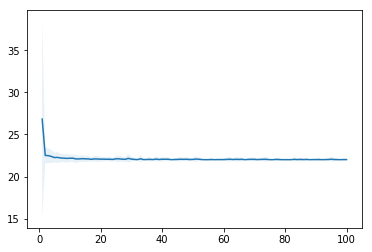

In [7]:
# CartPole

actions = ("L","R")
action_id = {"L":0,"R":1}
def policy_random(state,actions):
    return random.choice(actions)


max_angle = math.pi/2
min_angle = -math.pi/2
max_t = int(20.2/.02)
max_x = 3
min_x = -3
def termination_func(state,time):
    vel,pos,ang_vel,theta = state    
    return (pos > max_x or pos<min_x or theta<min_angle or theta>max_angle or time >= max_t) 
def reward_func(state,action):
    if termination_func(state,0):
        return 0
    else:
        return 1
    
delta_t = .02
m_p = .1
m_c = 1
mcp = m_c+m_p
l = .5
motor_force = 10 #in newtons
g = 9.8

def transition_func(state,action):
    vel,pos,ang_vel,theta = state
    sin = math.sin(theta)
    cos = math.cos(theta)
    if action == 'L':
        F = -motor_force
    else:
        F = motor_force
    x = (F + l*m_p*sin*(ang_vel**2))/mcp
    ang_acc = (g*sin-cos*x)/(l*(4/3-m_p*cos**2/mcp))
    acc = (F+m_p*l*(sin*ang_vel**2-ang_acc*cos))/mcp
    #acc = x - l*m_p*ang_acc*cos/mcp

    pos += vel*delta_t
    theta += ang_vel*delta_t
    vel += acc*delta_t
    ang_vel += ang_acc*delta_t
    return (vel,pos,ang_vel,theta)

max_v = 10; min_v = -10
max_a = np.pi ; min_a = -np.pi
epsilon = .1
wide_max_x = max_x+epsilon ; wide_min_x = min_x-epsilon
wide_max_theta = max_angle+epsilon; wide_min_theta = min_angle-epsilon

n = 6 # 5 or 3
d = 4 
basis_matrix = np.array(list(product(range(n+1),repeat = d)),dtype=np.float64)
state_normalized = np.zeros(4,dtype=np.float64)
def normalize_basis(state): # normalize to 0 , 1
    global state_normalized
    state_normalized[0] = (state[0]-min_v)/(max_v-min_v)    
    state_normalized[1] = (state[1]-wide_min_x)/(wide_max_x-wide_min_x)
    state_normalized[2] = (state[2]-min_a)/(max_a-min_a)    
    state_normalized[3] = (state[3]-wide_min_theta)/(wide_max_theta-wide_min_theta)
def normalize_basis_11(state): # normalize to -1 , 1
    global state_normalized
    state_normalized[0] = 2*(state[0]-min_v)/(max_v-min_v) -1
    state_normalized[1] = 2*(state[1]-wide_min_x)/(wide_max_x-wide_min_x) -1
    state_normalized[2] = 2*(state[2]-min_a)/(max_a-min_a) -1 
    state_normalized[3] = 2*(state[3]-wide_min_theta)/(wide_max_theta-wide_min_theta) -1

def fourier_basis(state):
    normalize_basis(state)
    return np.cos(np.pi*np.dot(basis_matrix,state_normalized))
def polynomial_basis(state):
    normalize_basis_11(state)
    return np.product(np.power(state_normalized,basis_matrix),axis=1)

myMDP = imdp.infinite_state_MDP(actions,transition_func,reward_func,termination_func\
                                ,lambda : (0,0,0,0), 1, policy_random)
episodes = 100
repetitions = 100
y = np.zeros((episodes,repetitions))
j=0
maxG = 0
while j<repetitions:
    i = 0
    for G in imdp.Q(episodes,basis_matrix.shape[0],len(actions),action_id,.003,polynomial_basis,imdp.delta_linear,myMDP):
        y[i,j] = G
        i+=1
        maxG = max(maxG,G)
    j+=1
std = np.std(y,axis = 1)
mean = np.mean(y,axis = 1)

plt.plot(range(1,101),np.mean(y,axis = 1))
plt.fill_between(range(1,101), mean-std, mean+std,alpha  = .1)





In [12]:
maxG

1010

In [11]:
np.matmul(fourier_basis([0,.5,.5,.5]),imdp._w_)

array([ 54.03109588, 518.8175736 ])

In [14]:
basis_matrix.shape

(256, 4)